# Store Traffic Monitor

Store traffic monitor is an advanced use-case example, which builds on the two previous examples (<a href="../flaw-detector-python/flawdetector-demo.ipynb">flaw detector</a> and <a href="../object-detection-python/object_detection_demo.ipynb">object detector</a>) and shows how a user can perform object detection and inference on multiple videos simultaneously. In this use case, the application monitors the activity of people inside and outside an imaginary store as well as keeps track of product inventory using a pre-trained neural network for detection. This application is capable of detecting objects on any number of screens as long as sufficient compute power is available.

This demo assumes you have already tried the <a href="../object-detection-python/object_detection_demo.ipynb">object detector</a> sample. If you have not done so already, we recommend going through that sample first to understand the workflow for developing a deep learning application using OpenVINO. 

More information on using the store traffic monitor, as well as the original source code, can be found on GitHub:

https://github.com/intel-iot-devkit/store-traffic-monitor-python

Note that the code in this notebook has been slightly modified from the version on GitHub in order to work in the IoT DevCloud environment.

## Overview of How it works?

The counter uses the inference engine included in the OpenVINO™ toolkit. A trained neural network detects objects within a designated area and displays a green bounding box over them. This reference implementation identifies multiple intruding objects entering the frame and identifies their class, count, and time entered. 

At start-up, the sample application reads a configuration file and loads a network and images from the video input to the Inference Engine (IE) plugin. At runtime, computations are offloaded to a the hardware accelerator (Intel® Core CPU, Intel® HD Graphics GPU, Intel® Xeon CPU, Intel® Movidius™ and/or Neural Compute Stick). Once the inference is completed, the output videos are appropriately rendered and stored in the /results directory, which can then be viewed within the Jupyter Notebook instance

## Demonstration objectives
* Video as input is supported using **OpenCV**
* Inference performed on edge compute nodes with various target compute devices
* **OpenCV** provides the bounding boxes, labels and other information
* Visualization of the resulting bounding boxes
* Demonstrate the Async API in action

## Step 0: Setup

Import dependencies for the notebook by running the following cell

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *

## Step 1: Advanced OpenVINO

The complete listing of source code for this example is in <a href="store_traffic_monitor.py">store_traffic_monitor.py</a>.
This application takes multiple video streams as inputs. The application is designed to work in both sync and async mode. In sync mode, the processing is done by the compute device by taking one frame at a time, whereas in async mode, the device takes multiple frames and processes them in parallel.


**Configure the Application**

All the configurations are written to store-traffic-monitor-python/conf_fp*.txt. We have two configuration files: conf_fp16.txt and conf_fp32.txt  

- **conf_fp16.txt**: use if you want the inference to be run on Intel® Movidius™ Neural Compute Stick as it offers native FP16 precision.
- **conf_fp32.txt**: use if you want the inference to be run on Intel® Core CPU, Intel® HD Graphics GPU and Intel® Xeon CPU.

1st line: path/to/model.xml -> 
This is the path to the model topology in the local file system.
The model topology file is the .xml file that the model optimizer produces, containing the IR of the model's topology.

2nd line: path/to/model.bin ->
This is the path to the model weights in the local file system.
The model weights file is the .bin file that the model optimizer produces, containing the IR of the model's weights.

3rd line: path/to/labels ->
This is a path to the labels file in the local file system.
The labels file is a text file containing all the classes/labels that the model can recognize, in the order that it was trained to recognize them (one class per line). All detection models work with integer labels and not string labels (e.g. for the mobilenet-ssd model, the **number 15 represents the class "person"**).
For the mobilenet-ssd model, we provide the class file labels.txt in the **"/data/reference-sample-data/store-traffic-monitor-python"** folder.

**Note** : store_traffic_monitor application is used to detect a person and a bottle in a frame. For the mobilenet-ssd model used in this example, the line number 5 and  line number 15 in the labels.txt file correspond to bottle and person, respectively. If you are using a different model, then the items in labels.txt file would need to be adjusted appropriately.

Each of the following lines contain the path/to/video followed by the label to be detected on that video, e.g.:

**/data/reference-sample-data/store-traffic-monitor-python/people-detection.mp4** person

The path/to/video is the path, in the local file system, to a video that is used as input. The labels used must coincide with the labels from the labels file.

**Models to Use ?**

The application works with any object-detection model, provided it has the same input and output format of the mobilenet-ssd model.
The model can be any object detection model:

* that is provided by OpenVINO™ toolkit.
These can be found in the openvino/deployment_tools/intel_models folder.
* downloaded using the model downloader.
These can be found in the openvino/deployment_tools/model_downloader/object_detection folder.
* created by the user

For first-time use, we recommend using the mobilenet-ssd model provided as a part of this application. The models can be found under the folder "/data/reference-sample-data/models/mobilenet-ssd"

**Videos to Use ?**

The application works with any input video. Sample videos for object detection are provided here.

For first-use, we recommend using the people-detection, one-by-one-person-detection, bottle-detection videos.
E.g.:

/data/reference-sample-data/store-traffic-monitor-python/people-detection.mp4 person<br>
/data/reference-sample-data/store-traffic-monitor-python/one-by-one-person-detection.mp4 person<br>
/data/reference-sample-data/store-traffic-monitor-python/bottle-detection.mp4 bottle

For the sake of simplicity, the videos are copied into /data/reference-sample-data/store-traffic-monitor-python/ folder

**Command line arguments options and how they are interpreted in the application source code**

```python
** python3 store_traffic_monitor.py -d CPU -c conf_fp32.txt -o results **
```

#### The description of the arguments used in the argument parser is the command line executable equivalent.

 *  -o  location where the output file with inference results needs to be stored. (results/core or results/xeon or results/gpu or results/myriad)

 *  -d Type of Hardware Acceleration (CPU or GPU or MYRIAD)
 *  -c configuration file to use ("conf_fp32.txt" for Intel® Core CPU, Intel® HD Graphics GPU and Intel® Xeon CPU. "conf_fp16.txt" for Intel® Movidius™ Neural Compute Stick)

### 1.1 Choosing Device
First, we must select the device used for inferencing. This is done by loading the appropriate plugin to initialize the specified device (CPU, GPU, MYRIAD etc) and load the extensions library (if specified) provided in the extension/ folder for the device.

The plugin class is IEPlugin and can be constructed as follows:
```python
    # Parses the configuration file "conf.txt" and reads model_xml, model_bin, labels_file, videoCaps
    parse_conf_file()
    # Plugin initialization for specified device and load extensions library
    print("Initializing plugin for {} device...".format(TARGET_DEVICE))
    plugin = IEPlugin(device=TARGET_DEVICE)
    if 'CPU' in TARGET_DEVICE:
        plugin.add_cpu_extension(CPU_EXTENSION)
```

**Note**: Currently, three types of plugins are supported: CPU, GPU, and MYRIAD. The CPU plugin may require additional extensions to improve performance. Use add_cpu_extension function to load these additional extensions.

### 1.2 Read the IR (Intermediate Representation) model

Intel Model Optimizer creates Intermediate Representation (IR) models that are optimized for different Intel hardware.
We can import these optimized models (weights) into our neural network using **`IENetwork`**. 
```python
    net = IENetwork.from_ir(model=model_xml, weights=model_bin)
    assert len(net.inputs.keys()) == 1, "Sample supports only single input topologies"
    assert len(net.outputs) == 1, "Sample supports only single output topologies"
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
```

### 1.3 Load the network into the plugin

Once we have the plugin and the network, we can load the IR into the plugin using **`plugin.load`**.

```python
    # Loading IR model to the plugin.
    exec_net = plugin.load(network=net, num_requests=2)
    # Read and pre-process input image
    n, c, h, w = net.inputs[input_blob]
    del net

```

### 1.4 Start video capture using OpenCV 

Now we are ready to capture the frames from the video sample using **OpenCV VideoCapture** API.
Upon getting the frame we are ready to perform inference.

```python
cap = cv2.VideoCapture(input_stream)
```


### 1.5 Prepare the Model

Run the cells below to download the mobilenet-ssd model and convert it using the Intel Model Optimizer.

In [2]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --print_all

action-recognition-0001-decoder
action-recognition-0001-encoder
age-gender-recognition-retail-0013
driver-action-recognition-adas-0002-decoder
driver-action-recognition-adas-0002-encoder
emotions-recognition-retail-0003
face-detection-adas-0001
face-detection-adas-binary-0001
face-detection-retail-0004
face-detection-retail-0005
face-reidentification-retail-0095
facial-landmarks-35-adas-0002
gaze-estimation-adas-0002
handwritten-score-recognition-0003
head-pose-estimation-adas-0001
human-pose-estimation-0001
image-retrieval-0001
inceptionv3-int8-sparse-v1-tf-0001
inceptionv3-int8-sparse-v2-tf-0001
inceptionv3-int8-tf-0001
instance-segmentation-security-0010
instance-segmentation-security-0050
instance-segmentation-security-0083
landmarks-regression-retail-0009
license-plate-recognition-barrier-0001
mobilenetv2-int8-sparse-v1-tf-0001
mobilenetv2-int8-sparse-v2-tf-0001
mobilenetv2-int8-tf-0001
pedestrian-and-vehicle-detector-adas-0001
pedestrian-detection-adas-0002
pedestrian-detection-a

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6 

In [4]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd -o raw_models

################|| Downloading models ||################

========== Downloading raw_models/public/mobilenet-ssd/mobilenet-ssd.prototxt
... 100%, 28 KB, 61741 KB/s, 0 seconds passed

========== Downloading raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 20987 KB/s, 1 seconds passed

################|| Post-processing ||################



In [5]:
!/opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
--input_model raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel \
--data_type FP32 \
-o models/mobilenet-ssd/FP32 \
--scale 256 \
--mean_values [127,127,127] 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u35428/iot-devcloud/python/store-traffic-monitor-python/raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u35428/iot-devcloud/python/store-traffic-monitor-python/models/mobilenet-ssd/FP32
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Path to Python Caffe* parser generated from caffe.proto: 	/opt/intel/openvino/deployment_tools/model_optimizer/mo/

In [6]:
!/opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
--input_model raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel \
--data_type FP16 \
-o models/mobilenet-ssd/FP16 \
--scale 256 \
--mean_values [127,127,127] 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u35428/iot-devcloud/python/store-traffic-monitor-python/raw_models/public/mobilenet-ssd/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u35428/iot-devcloud/python/store-traffic-monitor-python/models/mobilenet-ssd/FP16
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Path to Python Caffe* parser generated from caffe.proto: 	/opt/intel/openvino/deployment_tools/model_optimizer/mo/

## Step 2: Running on the IoT DevCloud

### 2.1 Creating job file

Like in the object detection example, we will perform inference on multiple edge compute devices by submitting jobs into the IoT DevCloud queue. To do this, first, we need to create a job file.
The job file is a Bash script, and will be executed on the edge compute node.
For this example, we have written the job file for you in the notebook.
Run the following cell to write this in to the file "store_traffic_manager_job.sh"

In [7]:
%%writefile store_traffic_monitor_job.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

OUTPUT_FILE=$1
DEVICE=$2
FP_MODEL=$3
NUM_VIDEOS=$4

# Traffic monitor script writes output to a file inside a directory. We make sure that this directory exists.
#  The output directory is the first argument of the bash script
mkdir -p $1

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    #source /opt/fpga_support_files/setup_env.sh
    source /opt/intel/init_openvino.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_sg1_bitstreams/2019R3_PV_PL1_FP16_RMNet.aocx
fi

if [ "$FP_MODEL" = "FP32" ]; then
    config_file="conf_fp32.txt"  
else
    config_file="conf_fp16.txt"
fi

SAMPLEPATH=$PBS_O_WORKDIR
# Traffic monitor takes 3 inputs, which are passed in as arguments to the bash script. 
#  -o : output directory of the videos
#  -d : device to use for inference
#  -c : conf file to use
#  -n : number of videos to process

python3 store_traffic_monitor.py  -d $DEVICE \
                                    -m ${SAMPLEPATH}/models/mobilenet-ssd/${FP_MODEL}/mobilenet-ssd.xml \
                                    -l labels.txt \
                                    -e /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so \
                                    -lp false \
                                    -o $OUTPUT_FILE \
                                    -c $config_file \
                                    -n $NUM_VIDEOS

Writing store_traffic_monitor_job.sh


### 2.2 Submitting to Job Queue

Now that we have the job script, we can submit the jobs to compute nodes using the `qsub` command.
Let's try submitting the store_traffic_monitor job to 5 different types of nodes.

There are three options of `qsub` command that we use for this:
- `-l` : this option lets us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option lets us send arguments to the bash script. 
- `-N` : this option lets us name the job so that it is easier to distinguish between them.

To see the available types of nodes (e.g. properties) on the IoT DevCloud, run the following cell.

In [8]:
!pbsnodes | grep compnode | sort | uniq -c

     35      properties = idc001skl,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe
     15      properties = idc002mx8,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-r,iei-mustang-v100-mx8
     17      properties = idc003a10,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-f,iei-mustang-f100-a10
     23      properties = idc004nc2,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,ncs,intel-ncs2
      6      properties = idc006kbl,compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
     13      properties = idc007xv5,compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,ram32gb,net1gbe
     15      properties = idc008u2g,compnode,up-squared,grove,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe,ncs,intel-ncs2
      1      properties = idc009jkl,compnode,jwip,intel-core,i5-7500,kaby-lake,intel-hd-630,ram8gb,n

Here, the properties describe the node, and number on the left is the number of available nodes.

Now let's actually submit the jobs. 
The 5 code cells below will submit jobs to nodes with different architectures.
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

#### submitting to a node with Intel® Core CPU

In [9]:
print("Submitting a job to an edge compute node with an Intel Core CPU...")
#Submit job to the queue
job_id_core =!qsub store_traffic_monitor_job.sh -l nodes=1:tank-870:i5-6500te -F "results/core CPU FP32 3" -N monitor_core
print(job_id_core[0])
#Progress indicators
if job_id_core:
    progressIndicator('results/core', 'i_progress_'+job_id_core[0]+'.txt', "Inference", 0, 100)

Submitting a job to an edge compute node with an Intel Core CPU...
5714.v-qsvr-1.devcloud-edge


#### submitting to a node with Intel® Xeon CPU

In [10]:
print("Submitting a job to an edge compute node with an Intel Xeon CPU...")
#Submit job to the queue
job_id_xeon = !qsub store_traffic_monitor_job.sh -l nodes=1:tank-870:e3-1268l-v5 -F "results/xeon CPU FP32 3" -N monitor_xeon
print(job_id_xeon[0])
if job_id_xeon:
    progressIndicator('results/xeon', 'i_progress_'+job_id_xeon[0]+'.txt', "Inference", 0, 100)    

Submitting a job to an edge compute node with an Intel Xeon CPU...
5715.v-qsvr-1.devcloud-edge


#### submitting to a node with Intel® Core CPU and using the onboard Intel GPU

In [11]:
print("Submitting a job to an edge compute node with an Intel Core CPU and an Intel GPU...")
#Submit job to the queue
job_id_gpu = !qsub store_traffic_monitor_job.sh -l nodes=1:tank-870:i5-6500te:intel-hd-530 -F "results/gpu GPU FP32 3" -N monitor_gpu
print(job_id_gpu[0])
#Progress indicators
if job_id_gpu:
    progressIndicator('results/gpu', 'i_progress_'+job_id_gpu[0]+'.txt', "Inference", 0, 100)

Submitting a job to an edge compute node with an Intel Core CPU and an Intel GPU...
5716.v-qsvr-1.devcloud-edge


#### Submitting to a node with Intel® Movidius Neural Compute Stick 2

In [12]:
print("Submitting a job to an edge compute node with Intel Movidius NCS 2...")
#Submit job to the queue
job_id_myriad = !qsub store_traffic_monitor_job.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "results/myriad MYRIAD FP16 3" -N monitor_myriad
print(job_id_myriad[0])
#Progress indicators
if job_id_myriad:
    progressIndicator('results/myriad', 'i_progress_'+job_id_myriad[0]+'.txt', "Inference", 0, 100)

Submitting a job to an edge compute node with Intel Movidius NCS 2...
5717.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with UP Squared Grove IoT Development Kit (UP2)

In [13]:
print("Submitting a job to an edge compute node with UP Squared...")
#Submit job to the queue
job_id_up2 = !qsub store_traffic_monitor_job.sh -l nodes=1:up-squared -F "results/up2/ GPU FP32 3" -N monitor_up2
print(job_id_up2[0]) 
#Progress indicators
if job_id_up2:
    progressIndicator('results/up2/', 'i_progress_'+job_id_up2[0]+'.txt', "Inference", 0, 100)

Submitting a job to an edge compute node with UP Squared...
5718.v-qsvr-1.devcloud-edge


#### submitting to a node with Intel FPGA HDDL-F (High Density Deep Learning)

In [14]:
print("Submitting a job to an edge compute node with Intel FPGA HDDL-F...")
#Submit job to the queue
job_id_fpga = !qsub store_traffic_monitor_job.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-f100-a10 -F "results/fpga HETERO:FPGA,CPU FP32 3" -N monitor_fpga
print(job_id_fpga[0])
#Progress indicators
if job_id_fpga:
    progressIndicator('results/fpga', 'i_progress_'+job_id_fpga[0]+'.txt', "Inference", 0, 100)

Submitting a job to an edge compute node with Intel FPGA HDDL-F...
5719.v-qsvr-1.devcloud-edge


#### Submitting to a node with Intel Mustang V100-MX8 HDDL-R

In [15]:
print("Submitting a job to an edge compute node with Intel HDDL-R...")
#Submit job to the queue
job_id_hddlr = !qsub store_traffic_monitor_job.sh -l nodes=1:idc002mx8:iei-mustang-v100-mx8 -F "results/hddlr HDDL FP16 3" -N monitor_hddlr
print(job_id_hddlr[0])
#Progress indicators
if job_id_hddlr:
    progressIndicator('results/hddlr', 'i_progress_'+job_id_hddlr[0]+'.txt', "Inference", 0, 100)

Submitting a job to an edge compute node with Intel HDDL-R...
5720.v-qsvr-1.devcloud-edge


### 2.3 Check if the jobs are done

Run the following cell to bring up the qstat widget and monitor the running jobs. 

In [16]:
liveQstat()

Output(layout=Layout(border='1px solid gray', width='100%'))

Button(description='Stop', style=ButtonStyle())

You should see the jobs you have submitted (referenced by `Job ID`).
It should also show a job in the queue "jupyterhub", which runs the present Jupyter Notebook session. 
In the column "S", you can find the status of each job. "Q" means that the job is waiting for resources in the queue. "R" means that the job is running. When the a job is running, the progress indicators underneath the cells that submitedt that job will tell you how far the job has progressed.

**Wait!**

Before moving to step 3, make sure that all the monitor_*  jobs submitted to the queue are completed.

## Step 3: Results

Once the jobs are complete, the queue software writes the stdout and stderr streams into files with names of the form

`monitor_{type}.o{JobID}`

`monitor_{type}.e{JobID}`

(here, the prefix `monitor_{type}` is based on our `-N` argument of `qsub`)

However, for our store monitor example, rather than studying stdout/stderr, you will likely be more interested in viewing the main output in the mp4 videos that are stored in the `results/` directory.
We wrote a short utility script that will display these videos in the notebook. Run the cells below to view the video.
See `demoutils.py` if interested in the script.

Then run the following four cells to see the output  from out jobs.

In [ ]:
videoHTML('IEI Tank (Intel® Core CPU)',
          ['results/core/inference_output_Video_0.mp4',
           'results/core/inference_output_Video_1.mp4', 
           'results/core/inference_output_Video_2.mp4', 
           'results/core/Statistics.mp4'],
           'results/core/stats.txt')

In [ ]:
videoHTML('IEI Tank Xeon (Intel® Xeon CPU)',
          ['results/xeon/inference_output_Video_0.mp4',
           'results/xeon/inference_output_Video_1.mp4',
           'results/xeon/inference_output_Video_2.mp4',
           'results/xeon/Statistics.mp4'],
           'results/xeon/stats.txt')

In [ ]:
videoHTML('IEI Intel GPU (Intel® Onboard GPU)',
          ['results/gpu/inference_output_Video_0.mp4',
           'results/gpu/inference_output_Video_1.mp4',
           'results/gpu/inference_output_Video_2.mp4',
           'results/gpu/Statistics.mp4'],
           'results/gpu/stats.txt')

In [ ]:
videoHTML('IEI Tank + Myriad (Intel® Core + Movidius NCS 2)',
          ['results/myriad/inference_output_Video_0.mp4',
           'results/myriad/inference_output_Video_1.mp4', 
           'results/myriad/inference_output_Video_2.mp4', 
           'results/myriad/Statistics.mp4'],
           'results/myriad/stats.txt')

In [ ]:
videoHTML('UP Squared Grove IoT Development Kit (UP2)',
          ['results/up2/inference_output_Video_0.mp4',
           'results/up2/inference_output_Video_1.mp4',
           'results/up2/inference_output_Video_2.mp4',
           'results/up2/Statistics.mp4'],
           'results/up2/stats.txt')

In [ ]:
videoHTML('IEI Tank + Intel FPGA HDDL-F',
          ['results/fpga/inference_output_Video_0.mp4',
           'results/fpga/inference_output_Video_1.mp4',
           'results/fpga/inference_output_Video_2.mp4',
           'results/fpga/Statistics.mp4'],
           'results/fpga/stats.txt')

## Step 4: Assess Performance

The running time of each inference task is recorded in `results/*/stats.txt`, where the subdirectory name corresponds to the architecture of the target edge compute node. Run the cell below to plot the results of all jobs side-by-side. Lower values mean better performance. Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

# Overload summaryPlot for Latency Plot

In [17]:
def summaryPlot(results_list, x_axis, y_axis, title, plot):
    ''' Bar plot input:
	results_dict: dictionary of path to result file and label {path_to_result:label}
	x_axis: label of the x axis
	y_axis: label of the y axis
	title: title of the graph
    '''
    warnings.filterwarnings('ignore')
    if plot=='time':
        clr = 'xkcd:blue'
    elif plot=='fps':
        clr = 'xkcd:azure'
    elif plot == "latency":
        clr = 'xkcd:red'


    plt.figure(figsize=(15, 8))
    plt.title(title , fontsize=28, color='black', fontweight='bold')
    plt.ylabel(y_axis, fontsize=16, color=clr)
    plt.xlabel(x_axis, fontsize=16, color=clr)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    val = []
    arch = []
    diff = 0
    for path, hw in results_list:
        if os.path.isfile(path):
            f = open(path, "r")
            l1_time = float(f.readline())
            l2_count = float(f.readline())
            if plot=="time":
                val.append(l1_time)
            elif plot == "fps":
                # print (l2_count/l1_time)
                # print (" for " + str(hw) + "\n")
                # fps data
                val.append((l2_count/l1_time))
            elif plot == "latency":
                batch = batch_dic[hw]
                # print(str(hw) +  "  " + str(batch))
                fps = float(batch) * 1.0/float(l2_count/l1_time) * 1000 # convert to ms
                val.append(fps)
            f.close()
        else:
            val.append(0)
        arch.append(hw)

    offset = max(val)/100
    # print("offset: " + str(offset)) text offset from the top of bar
    for v in val:
        if v == 0:
            data = 'N/A'
            y = 0
        else:
            precision = 2 
            if v >= pow(10, precision):
                data = '{:.0f}'.format(round(v/pow(10, precision+1), precision)*pow(10, precision+1))
            else:
                data = '{{:.{:d}g}}'.format(round(precision)).format(v)
            y = v + offset
            # print("y is: " + str(y)) text vertical position
        # print("data is: " + str(data) + " v is: " + str(v))
        plt.text(diff, y, data, fontsize=14, multialignment="center",horizontalalignment="center", verticalalignment="bottom",  color='black')
        diff += 1
    # print(val)
    plt.ylim(top=(max(val)+10*offset))
    plt.bar(arch, val, width=0.8, align='center', color=clr)

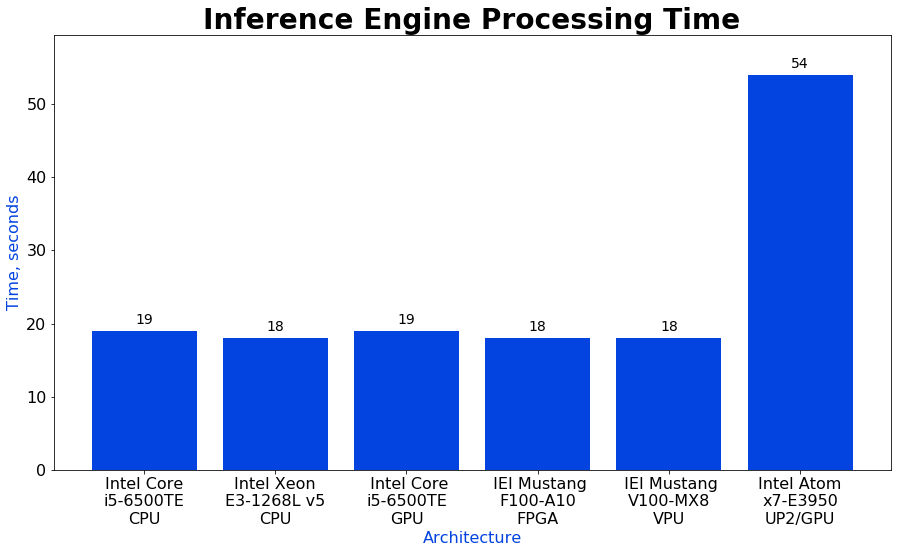

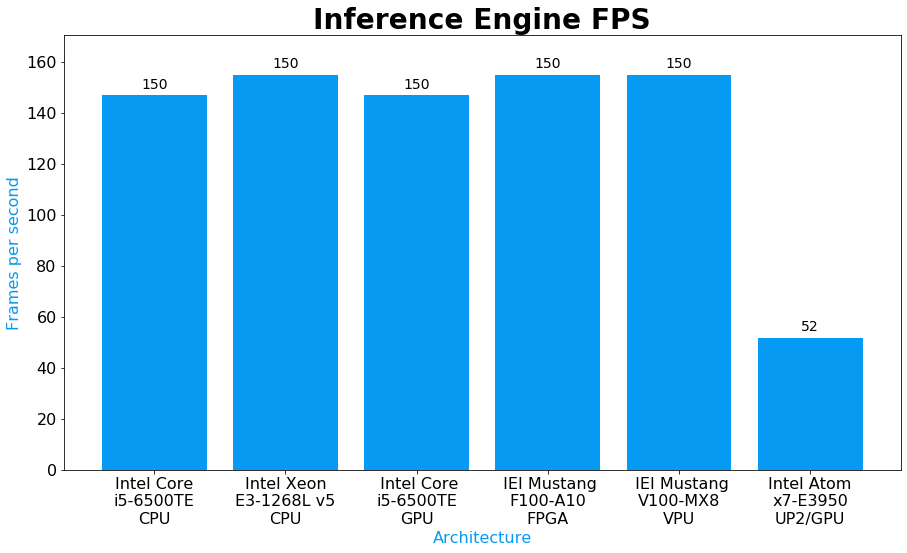

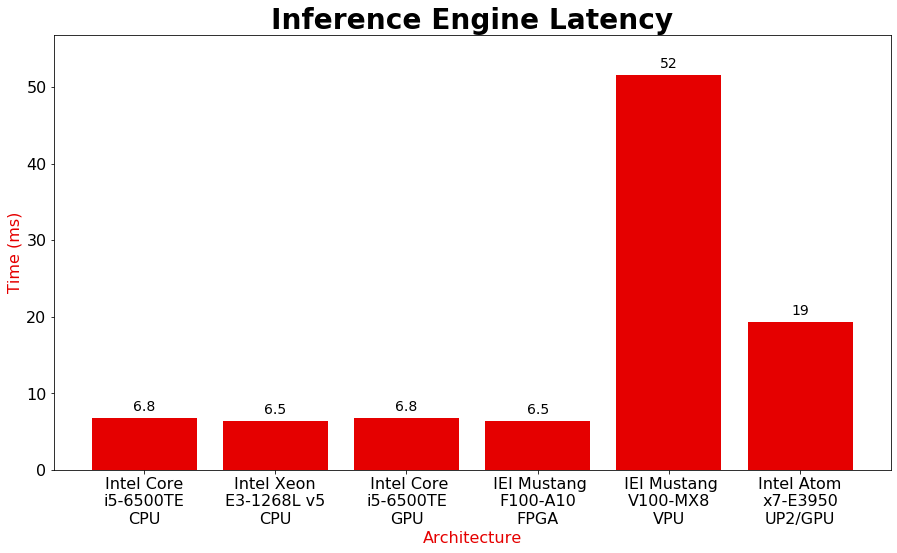

In [20]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('fpga', ' IEI Mustang\nF100-A10\nFPGA'),
             ('hddlr', ' IEI Mustang\nV100-MX8\nVPU'),
             ('up2', 'Intel Atom\nx7-E3950\nUP2/GPU')]

# Batch size currently use for demo
batch_dic = {"Intel Core\ni5-6500TE\nCPU": 1, "Intel Xeon\nE3-1268L v5\nCPU": 1,
         " Intel Core\ni5-6500TE\nGPU": 1, " IEI Mustang\nF100-A10\nFPGA": 1,
         " IEI Mustang\nV100-MX8\nVPU": 8, "Intel\nNCS2": 1, "Intel Atom\nx7-E3950\nUP2/GPU": 1}

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/'+arch+'/stats.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )

# Latency Plot
summaryPlot(stats_list, 'Architecture', 'Time (ms)', 'Inference Engine Latency', 'latency')